# Практическая часть

Код для src, utils, metrics вы можете скачать с [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [439]:
data = pd.read_csv('../webinar_2/webinar_2/data/retail_train.csv')
item_features = pd.read_csv('../webinar_2/webinar_2/data/product.csv')
user_features = pd.read_csv('../webinar_2/webinar_2/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [440]:
#удалим user_id 1813, 1984, 296, 2259 для того, чтобы не было холодного старта
data = data.drop(data[data.user_id == 1813].index)
data = data.drop(data[data.user_id == 1984].index)
data = data.drop(data[data.user_id == 296].index)
data = data.drop(data[data.user_id == 2259].index)

user_features = user_features.drop(user_features[user_features.user_id == 1813].index)
user_features = user_features.drop(user_features[user_features.user_id == 1984].index)
user_features = user_features.drop(user_features[user_features.user_id == 296].index)
user_features = user_features.drop(user_features[user_features.user_id == 2259].index)

In [441]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [447]:
u1 = list(data_train_lvl_1['user_id'].unique())

In [448]:
u2 = list(data_val_lvl_1['user_id'].unique())

In [449]:
u3 = list(data_val_lvl_2['user_id'].unique())

In [450]:
users_for_del = []
for elem in u3:
    if elem not in u2:
        users_for_del.append(elem)
for elem in u2:
    if elem not in u1:
        users_for_del.append(elem)

In [454]:
#убираем все юзеры которые есть в третьей части но нет во второй, и которые есть во второй части но нет в первой
for elem in users_for_del:
    data = data.drop(data[data.user_id == elem].index)

In [455]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [457]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 82432 to 5001


In [458]:
recommender = MainRecommender(data_train_lvl_1)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [459]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1106523, 1000753, 844179]

In [460]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [461]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 917816, 1042907, 15778319, 907099]

In [462]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 1080888, 977559, 1055403, 7082640]

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [463]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [464]:
# your_code

In [465]:
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['sim_it_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['sim_us_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [466]:
result_lvl_1.head(2)

,user_id,actual,als_rec,own_rec,sim_it_rec,sim_us_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[9526630, 867547, 5572884, 6534030, 8090556, 1...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 1102067, 9...","[1135983, 916990, 979674, 1115800, 832678, 996..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 916122, 1104414, 831063, 1017369, 86...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 917816, 819978, 1132178, 98...","[911974, 1012627, 1091090, 9419422, 1138596, 7..."


In [467]:
print(result_lvl_1.apply(lambda row: recall_at_k(row['als_rec'], row['actual'], k=50), axis=1).mean())
print(result_lvl_1.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean())
print(result_lvl_1.apply(lambda row: recall_at_k(row['sim_it_rec'], row['actual'], k=50), axis=1).mean())
print(result_lvl_1.apply(lambda row: recall_at_k(row['sim_us_rec'], row['actual'], k=50), axis=1).mean())

0.04884824274182977
0.06494465249431222
0.03367408111527047
0.007078740686781439


Лучший recall дает get_own_recommendations - 0.0649

In [468]:
#train
popularity = data_train_lvl_1.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_25 = popularity.sort_values('n_sold', ascending=False).head(25).item_id.tolist()

In [469]:
result_lvl_1['own_rec_and_top'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=25)+top_25)

In [470]:
print(result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_and_top'], row['actual'], k=50), axis=1).mean())

0.07129752728911641


## Дают ли own recommendtions + top-popular лучший recall?  ДА, дает
и recall равен 0.0712

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500} 

In [471]:
recall_all = []
k_all = [20, 50, 100, 200, 500]
for m in k_all:
    result_lvl_1['own_rec_k'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=m))
    recall_all.append(result_lvl_1.apply(lambda row: recall_at_k(row['own_rec_k'], row['actual'], k=m), axis=1).mean())

In [472]:
recall_all

[0.03896988252121308,
 0.06494465249431222,
 0.09571977855830535,
 0.13486145099721777,
 0.18146647315698164]

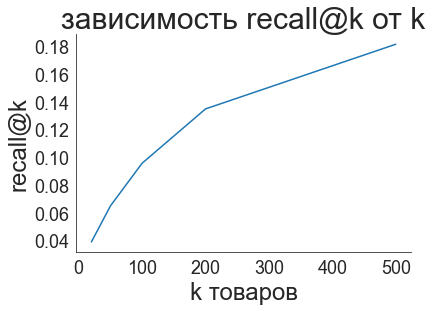

In [473]:
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(k_all, recall_all);
plt.xlabel('k товаров', fontsize=24);
plt.ylabel('recall@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('зависимость recall@k от k', fontsize=30);

вывод : recall зависит от k, засисимость не линейная, но возрастающая
разумным является максимальное количество товаров, которое пользователь может просмотреть( на сайте, в приложении и тд)
наверно не больше 100 товаров
ну или можно разбивать товары по категориям и предлагать по разделам, чтобы уменьшить список

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [474]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

In [475]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [476]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [477]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [478]:
users_lvl_2.shape[0]

107550

In [479]:
users_lvl_2['user_id'].nunique()

2151

In [480]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки


In [481]:
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [482]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [483]:
targets_lvl_2['target'].mean()

0.10416049016701255

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

In [484]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [485]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [486]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [487]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [488]:
targets_lvl_2.shape

(111309, 16)

In [489]:
targets_lvl_2 = targets_lvl_2.drop_duplicates()
targets_lvl_2.reset_index(drop=True, inplace = True)

In [490]:
targets_lvl_2.shape

(106972, 16)

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [491]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [492]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [494]:
lgb = LGBMClassifier(objective='binary', max_depth=4, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

1 соединить X_train и predict_proba
2 сделать функцию где по каждому юзеру выбирается топ 5 отсортированных predict_proba
3 сделать на последнем тесте actual
4 добавить для каждого юзера отсортированные предложения
5 посчитать 

In [495]:
X_train['proba'] = pd.Series(X_train.index).apply(lambda x: train_preds[x][1])

In [497]:
for_recomm_5 = X_train.copy()

In [498]:
for_recomm_5[for_recomm_5['user_id']==2070].sort_values('proba', ascending=False).head(5).item_id.tolist()

[928263, 1099905, 970866, 1092937, 1016298]

In [499]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [500]:
result_lvl_2['predict'] = result_lvl_2['user_id'].apply(lambda x: for_recomm_5[for_recomm_5['user_id']==x].sort_values('proba', ascending=False).head(5).item_id.tolist())

In [501]:
result_lvl_2

,user_id,actual,predict
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 826695, 8293439, 992986, 10457591]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 6979393, 1098844, 12757544, 825541]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 1010051, 916575, 9338009, 993838]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[5577022, 6391134, 850834, 919963, 878636]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1056509, 896085, 1056005, 5570408, 1128244]"
...,...,...,...
1910,2496,[6534178],"[1056509, 1069003, 831509, 865511, 1120928]"
1911,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1135834, 1120361, 951164, 870515, 1050741]"
1912,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1073775, 1022066, 849578, 1076580, 994223]"
1913,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6904613, 9523059, 901460, 962991, 835819]"


In [502]:
result_lvl_2.apply(lambda row: recall_at_k(row['predict'], row['actual'], k=5), axis=1).mean()

0.014883023789436083

## добавим фичи

In [612]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [613]:
targets_lvl_2

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
...,...,...,...
111304,1745,9419888,0.0
111305,1745,1092588,0.0
111306,1745,1076769,0.0
111307,1745,1024051,0.0


In [614]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

Фичи user_id: -  количество корзин за период(сколько раз ходил в магазин)

In [615]:
#список user
user_list = targets_lvl_2['user_id']
len(user_list)

111309

In [616]:
count_list = []

In [617]:
%%time
for user in user_list:
    count_list.append(data_train_lvl_2[data_train_lvl_2['user_id'] == user]['basket_id'].nunique())

CPU times: user 1min 5s, sys: 356 ms, total: 1min 5s
Wall time: 1min 6s


In [618]:
targets_lvl_2['count_basket'] = count_list

**Фичи user_id:**
    - среднее количество товаров в корзине

In [619]:
#список user
user_list = targets_lvl_2['user_id']
len(user_list)

111309

In [620]:
quantity_list = []

In [621]:
%%time
for user in user_list:
    quantity_list.append(data_train_lvl_2[data_train_lvl_2['user_id'] == user]['quantity'].sum()/
                        len(data_train_lvl_2[data_train_lvl_2['user_id'] == user]['basket_id'].unique()))
    

CPU times: user 2min 9s, sys: 782 ms, total: 2min 10s
Wall time: 2min 11s


In [623]:
%%time
targets_lvl_2['mean_quant_basket'] = quantity_list

CPU times: user 15 ms, sys: 933 µs, total: 16 ms
Wall time: 16.5 ms


**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории

In [624]:
#список item
item_list = targets_lvl_2['item_id']
len(item_list)

111309

In [625]:
%%time
quantity_item_list = []
for item in item_list:
    quantity_item_list.append(data_train_lvl_2[data_train_lvl_2['item_id'] == item]['quantity'].sum()/
                        data_train_lvl_2['week_no'].nunique())

CPU times: user 2min 28s, sys: 2.02 s, total: 2min 30s
Wall time: 2min 31s


In [626]:
targets_lvl_2['item_count_in_week'] = quantity_item_list

In [628]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,count_basket,mean_quant_basket,item_count_in_week,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,43,408.139535,0.833333,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,43,408.139535,0.166667,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [629]:
targets_lvl_2.shape

(111309, 19)

In [630]:
targets_lvl_2 = targets_lvl_2.drop_duplicates()

In [631]:
targets_lvl_2.shape

(106972, 19)

In [632]:
targets_lvl_2.reset_index(drop=True, inplace = True)

In [633]:
targets_lvl_2.tail(2)

,user_id,item_id,target,count_basket,mean_quant_basket,item_count_in_week,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
106970,1745,1024051,0.0,1,5.0,6.333333,1508,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN MULTI SERVE ENTREES ALL,28 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
106971,1745,880469,0.0,1,5.0,0.000000,544,GROCERY,National,BAG SNACKS,CORN CHIPS,10 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [634]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [636]:
cat_feats = X_train.columns[5:].tolist()
#cat_feats.remove('count_basket')
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [638]:
lgb = LGBMClassifier(objective='binary', max_depth=4, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [639]:
X_train['proba'] = pd.Series(X_train.index).apply(lambda x: train_preds[x][1])

In [640]:
for_recomm_5 = X_train.copy()

In [642]:
result_lvl_2['predict_2'] = result_lvl_2['user_id'].apply(lambda x: for_recomm_5[for_recomm_5['user_id']==x].sort_values('proba', ascending=False).head(5).item_id.tolist())

In [643]:
result_lvl_2

,user_id,actual,predict,predict_2
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 826695, 8293439, 992986, 10457591]","[992986, 9655212, 856942, 8293439, 1121694]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 6979393, 1098844, 12757544, 825541]","[900802, 1098844, 12757544, 6979393, 878715]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 1010051, 916575, 9338009, 993838]","[1122358, 9338009, 990897, 939681, 9419422]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[5577022, 6391134, 850834, 919963, 878636]","[6391134, 1088683, 930385, 1095374, 5577022]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1056509, 896085, 1056005, 5570408, 1128244]","[1056509, 896085, 1029743, 862799, 893018]"
...,...,...,...,...
1910,2496,[6534178],"[1056509, 1069003, 831509, 865511, 1120928]","[1056509, 865511, 1069003, 995876, 831509]"
1911,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1135834, 1120361, 951164, 870515, 1050741]","[1135834, 870515, 1050741, 1053628, 965430]"
1912,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1073775, 1022066, 849578, 1076580, 994223]","[994223, 849578, 1073775, 1100379, 6979518]"
1913,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6904613, 9523059, 901460, 962991, 835819]","[919766, 1127328, 1138858, 889989, 6904613]"


In [644]:
result_lvl_2.apply(lambda row: recall_at_k(row['predict_2'], row['actual'], k=5), axis=1).mean()

0.01804855501567128

In [ ]:
первые 2 фичи увеличили реколл на 0,4 процента

    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [645]:
result_lvl_2['own_rec'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))

In [646]:
result_lvl_2

,user_id,actual,predict,predict_2,own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 826695, 8293439, 992986, 10457591]","[992986, 9655212, 856942, 8293439, 1121694]","[856942, 9297615, 5577022, 877391, 9655212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 6979393, 1098844, 12757544, 825541]","[900802, 1098844, 12757544, 6979393, 878715]","[13003092, 972416, 995598, 923600, 1084036]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 1010051, 916575, 9338009, 993838]","[1122358, 9338009, 990897, 939681, 9419422]","[998519, 896666, 7147142, 894360, 9338009]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[5577022, 6391134, 850834, 919963, 878636]","[6391134, 1088683, 930385, 1095374, 5577022]","[12808385, 981660, 939860, 7410201, 829722]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1056509, 896085, 1056005, 5570408, 1128244]","[1056509, 896085, 1029743, 862799, 893018]","[872146, 918046, 9655676, 985622, 1056005]"
...,...,...,...,...,...
1910,2496,[6534178],"[1056509, 1069003, 831509, 865511, 1120928]","[1056509, 865511, 1069003, 995876, 831509]","[872826, 983665, 991546, 1134296, 7441210]"
1911,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1135834, 1120361, 951164, 870515, 1050741]","[1135834, 870515, 1050741, 1053628, 965430]","[870515, 1117219, 1102207, 1057168, 1135834]"
1912,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1073775, 1022066, 849578, 1076580, 994223]","[994223, 849578, 1073775, 1100379, 6979518]","[1022066, 1076580, 1100379, 5565356, 931579]"
1913,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6904613, 9523059, 901460, 962991, 835819]","[919766, 1127328, 1138858, 889989, 6904613]","[7168055, 1128395, 6904613, 5570048, 889989]"


In [647]:
result_lvl_2.apply(lambda row: precision_at_k(row['own_rec'], row['actual'], k=5), axis=1).mean()

0.14924281984334203

In [648]:
result_lvl_2.apply(lambda row: precision_at_k(row['predict_2'], row['actual'], k=5), axis=1).mean()

0.1556135770234987

precision_at_5 увеличился на 0,5 процента при использовании двухуровневой модели